In [1]:
import os
import sys
sys.path.append('/home/levibaljer/GAN_suite')
# from models import networks3D
import torch
import torch.nn as nn
from torch.nn import init
import mamba_ssm
import causal_conv1d
import SimpleITK as sitk

/home/levibaljer/anaconda3/envs/unet/lib/python3.8/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/home/levibaljer/anaconda3/envs/unet/lib/python3.8/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/home/levibaljer/anaconda3/envs/unet/lib/python3.8/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/levibaljer/anaconda3/envs/unet/lib/python3.8/site-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch

In [3]:
print(sitk.__version__)

2.2.0


In [2]:
print(torch.__version__)

2.4.1+cu121


In [4]:
print(mamba_ssm.__version__)

2.2.2


In [6]:
import torchvision
print(torchvision.__version__)

0.19.1+cu121


In [3]:
#print python version
import sys
print(sys.version)

3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]


In [4]:
from utils.NiftiDataset import *

In [5]:
def Registration(image, label):

    image, image_sobel, label, label_sobel,  = image, image, label, label

    Gaus = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
    image_sobel = Gaus.Execute(image_sobel)
    label_sobel = Gaus.Execute(label_sobel)

    fixed_image = label_sobel
    moving_image = image_sobel

    initial_transform = sitk.CenteredTransformInitializer(fixed_image,
                                                          moving_image,
                                                          sitk.Euler3DTransform(),
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)

    registration_method = sitk.ImageRegistrationMethod()
    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.1)
    registration_method.SetInterpolator(sitk.sitkLinear)
    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100,
                                                      convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32),
                                                  sitk.Cast(moving_image, sitk.sitkFloat32))

    image = sitk.Resample(image, fixed_image, final_transform, sitk.sitkLinear, 0.0,
                                     moving_image.GetPixelID())

    return image, label

In [8]:
imagePath = "/media/hdd/levibaljer/Bonn/HF201/h201_ULF.nii.gz"
referencePath = "/media/hdd/levibaljer/KhulaFinal/TemplateKhula.nii"
outPath = "/media/hdd/levibaljer/Bonn/HF201/h201_ULF_reg.nii.gz"

image = sitk.ReadImage(imagePath)
reference = sitk.ReadImage(referencePath)

image, reference = Registration(image, reference)
# image = resample_sitk_image(image, spacing=(1.0,1.0,1.0), interpolator='linear')

sitk.WriteImage(image, outPath)

In [3]:
from models.networks3D import *
from models.residual_transformers import *

/home/levibaljer/anaconda3/envs/unet/lib/python3.8/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/levibaljer/anaconda3/envs/unet/lib/python3.8/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [5]:
NetDiscriminator = NLayerDiscriminator(1, 64, 3, norm_layer=nn.InstanceNorm3d, use_sigmoid='False')

In [6]:
print(NetDiscriminator)

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): InstanceNorm3d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv3d(512, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (12): Sigmoid()
  )
)


In [4]:
myNet1 = ResnetGenerator(1, 1, 64, norm_layer=nn.InstanceNorm3d, use_dropout=False, n_blocks=9)
myNet2 = residual_transformers3D.I2IMamba(
            'Res-ViT-B_16',
            input_dim=1,
            img_size=256,
            output_dim=1,
            vis=False
        )
myNet3 = residual_transformers3D.Res_CNN('Res-ViT-B_16', input_dim= 1, img_size=256, output_dim=1, vis=False)

In [5]:
print(myNet1)

ResnetGenerator(
  (model): Sequential(
    (0): ReplicationPad3d((3, 3, 3, 3, 3, 3))
    (1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1))
    (2): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (5): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (8): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReplicationPad3d((1, 1, 1, 1, 1, 1))
        (1): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (2): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
    

In [6]:
print(myNet2)

I2IMamba(
  (encoder_1): Sequential(
    (0): ReplicationPad3d((3, 3, 3, 3, 3, 3))
    (1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1))
    (2): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
  )
  (encoder_2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (encoder_3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (bottleneck_1): cmMambaWithCNN(
    (mamba_layer): MambaLayer(
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mamba1): Mamba(
        (in_proj): Linear(in_features=256, out_features=1024, bias=False)
        (conv1d): 

hd-bet -i /media/hdd/levibaljer/Combined_data/Fold1/test/gambas_3block_1k -o /media/hdd/levibaljer/Combined_data/Fold1/test/gambas_3block_1k_brainex

In [9]:
# import nibabel as nib

# def convert_nii_to_niigz(input_nii_path, output_niigz_path):
#     # Load the NIfTI file
#     img = nib.load(input_nii_path)
    
#     # Save as compressed NIfTI (.nii.gz)
#     nib.save(img, output_niigz_path)
    
#     print(f"Converted {input_nii_path} to {output_niigz_path}")

# # Example usage
# for i in range(20):
#     print(str(i).zfill(2))
#     inPath = "/media/hdd/levibaljer/Hype/LF/sub-HYPE" + str(i).zfill(2) + "_axi.nii"
#     outPath = "/media/hdd/levibaljer/Hype/LF_2/" + str(i).zfill(2) + "_axi.nii.gz"
#     convert_nii_to_niigz(inPath, outPath)

hd-bet -i /media/hdd/levibaljer/Uganda/SynthSR/40309.nii.gz -o /media/hdd/levibaljer/Uganda/SynthSR_brainex/40309.nii.gz

100.nii  124.nii  185.nii  239.nii  26.nii   51.nii
101.nii  128.nii  189.nii  23.nii   275.nii  52.nii
105.nii  133.nii  195.nii  242.nii  27.nii   67.nii
108.nii  13.nii   19.nii   245.nii  291.nii  99.nii
111.nii  168.nii  203.nii  262.nii  44.nii   9.nii
11.nii   172.nii  233.nii  263.nii  49.nii

hd-bet -i /media/hdd/levibaljer/Combined_data/Fold1/ULF_MRR_reg -o /media/hdd/levibaljer/Combined_data/Fold1/ULF_MRR_reg_brainex

hd-bet -i /media/hdd/levibaljer/Combined_data/Fold1/ULF_MRR_reg/synthsr_reg -o /media/hdd/levibaljer/Combined_data/Fold1/ULF_MRR_reg/brainex/synthsr --save_bet_mask

117.nii.gz  17.nii.gz   213.nii.gz  260.nii.gz  292.nii.gz  48.nii.gz  76.nii.gz  97.nii.gz
121.nii.gz  181.nii.gz  217.nii.gz  266.nii.gz  296.nii.gz  4.nii.gz   77.nii.gz
146.nii.gz  190.nii.gz  247.nii.gz  267.nii.gz  297.nii.gz  5.nii.gz   83.nii.gz
150.nii.gz  201.nii.gz  248.nii.gz  270.nii.gz  2.nii.gz    62.nii.gz  88.nii.gz
167.nii.gz  211.nii.gz  258.nii.gz  279.nii.gz  303.nii.gz  63.nii.gz  89.nii.gz
176.nii.gz  212.nii.gz  259.nii.gz  287.nii.gz  47.nii.gz   70.nii.gz  94.nii.gz

In [2]:
print(torch.__version__)

2.4.1+cu121


In [3]:
import sys
print(sys.version)

3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]


In [3]:
import torchvision

In [2]:
import mamba_ssm
print(mamba_ssm.__version__)

2.2.2


In [4]:
import numpy
print(numpy.__version__)

1.24.4


In [3]:
print(causal_conv1d.__version__)

1.4.0


In [ ]:
netD = networks3D.define_D(1 + 1, 64, 'n_layers',
                                            3, 'instance', True, 'normal', 0.02, [0])

In [ ]:
netD.eval()

In [ ]:
input = torch.rand(1, 2, 64, 64, 64)
print(input.shape)

In [ ]:
output = netD(input)

In [ ]:
print(output.shape)

In [ ]:
def exists(x):
    return x is not None

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv3d(dim, dim_out, (1, 3, 3), padding=(0, 1, 1))
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        return self.act(x)

In [ ]:
class WBlock(nn.Module):
    def __init__(self):
        super(WBlock, self).__init__()
        
        sequence = [nn.Upsample((32, 32, 16), mode='trilinear', align_corners=False),
                    Block(1, 32),
                    nn.Upsample((64, 64, 32), mode='trilinear', align_corners=False),
                    Block(32, 64),
                    nn.Upsample((128, 128, 64), mode='trilinear', align_corners=False),
                    Block(64, 32),
                    nn.Conv3d(32, 1, 1),
                    nn.Tanh()]

        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)

In [ ]:

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm3d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

In [ ]:
def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)
    init_weights(net, init_type, gain=init_gain)
    return net

In [ ]:
def define_W(init_type='normal', init_gain=0.02, gpu_ids=[]):
    return init_net(WBlock(), init_type, init_gain, gpu_ids)

In [ ]:
netW = define_W('normal', 0.02, [0])

In [ ]:
outW = netW(output)

In [ ]:
print(outW.shape)

In [ ]:
def convOutput(n, f, p, s):
    return ((n+(2*p)-f)/s) + 1

#### To do: set dimensions in W automatically based on patch size specifications -- first upsample = dim/(2**2), second upsample = dim/(2), third upsample = dim

In [ ]:
randImage = torch.rand(1, 1, 128, 128, 64).to('cuda:0')

In [ ]:
noisy_A = randImage * (1 + outW)

In [ ]:
print(noisy_A.shape)

## Dataloader

In [10]:
from utils.NiftiDataset import *
import utils.NiftiDataset as NiftiDataset
from torch.utils.data import DataLoader
min_pixel = int(0.1 * ((128 * 128 * 64) / 100))
trainTransforms = [
                NiftiDataset.Resample((0.45, 0.45, 0.45), False),
                NiftiDataset.Augmentation(),
                NiftiDataset.Padding((64, 64, 64)),
                NiftiDataset.RandomCrop((144, 256, 256), 0, min_pixel)
                ]
train_set = NiftiDataSet('/media/hdd/levibaljer/ExperimentingKhula', which_direction='AtoB', transforms=trainTransforms, shuffle_labels=False, train=True, outputIndices=True)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=8, pin_memory=True) 

In [2]:
print(len(train_set))

1


In [11]:
def get_data():
    for i, data in enumerate(train_loader):
        print(i)
        print(len(data))
        break
    return data

In [12]:
import matplotlib.pyplot as plt
data = get_data()

0
3


In [5]:
print(train_set.labels_list)

['/media/hdd/levibaljer/ExperimentingKhula/labels/0.nii.gz']


In [13]:
print(data[0].shape)
print(data[2])

torch.Size([1, 1, 144, 256, 256])
tensor([0])


In [ ]:
myImage = data[0].to('cuda:0')

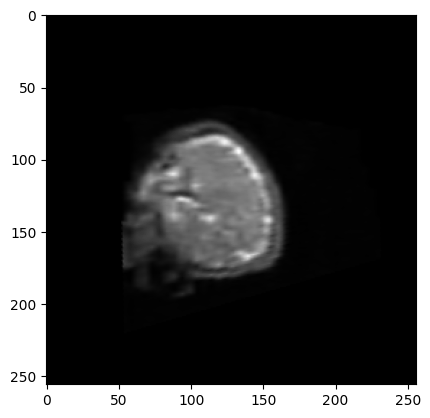

In [43]:
plt.imshow(data[0][0, 0, 32, :, :].cpu().numpy(), cmap='gray')

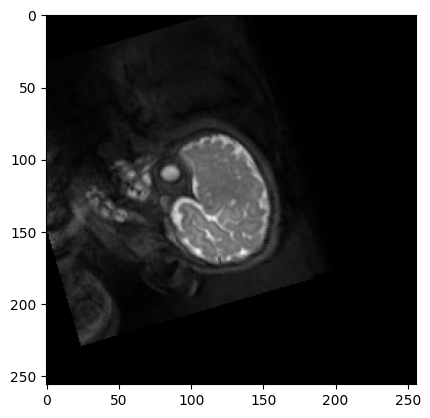

In [44]:
plt.imshow(data[1][0, 0, 32, :, :].cpu().numpy(), cmap='gray')

## DDPM

In [ ]:
from models import networks3D

In [ ]:
netG = networks3D.define_G(1, 1, 64, 'unet_256_ddm', 'instance',
                                      True, 'normal', 0.02, [0], 
                                      **{'dim': 64, 
                                         'dim_mults': (1,2,4,8), 
                                         'init_dim': 64, 
                                         'resnet_groups': 8})

In [ ]:
print(type(netG))

In [ ]:
disc_out = 0.5 + 0.001 * torch.randn((1, 1, 14, 14, 6), dtype=torch.float32)

In [ ]:
print(disc_out.shape)

In [ ]:
outW = netW(disc_out)

In [ ]:
print(outW.shape)

In [ ]:
myImage.get_device()

In [ ]:
noisy_Input = data[0] * (1 + outW)

## ResViT encoder

In [4]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from scipy import ndimage
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import copy

In [5]:
class Encoder(nn.Module):
    def __init__(self, config, vis):
    # def __init__(self, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(12):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

In [6]:
class ResViT(nn.Module):
    # def __init__(self,config, input_dim, img_size=224, output_dim=3, vis=False):
    def __init__(self, input_dim, output_dim=3, vis=False):
        super(ResViT, self).__init__()
        # self.transformer_encoder = Encoder(config, vis)
        # self.config = config
        output_nc = output_dim
        ngf = 64
        use_bias = False
        # norm_layer = nn.BatchNorm2d # switch to instance or groupNorm in 3D
        norm_layer = nn.InstanceNorm3d
        padding_type = 'reflect'
        mult = 4

        ############################################################################################
        # Layer1-Encoder1
        # model = [nn.ReflectionPad2d(3),
        #          nn.Conv2d(input_dim, ngf, kernel_size=7, padding=0,
        #                    bias=use_bias),
        #          norm_layer(ngf),
        #          nn.ReLU(True)]
        
        model = [nn.ReflectionPad3d(3),
                 nn.Conv3d(input_dim, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        setattr(self, 'encoder_1', nn.Sequential(*model))
        ############################################################################################
        # Layer2-Encoder2
        n_downsampling = 2
        model = []
        i = 0
        mult = 2 ** i
        # model = [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
        #                    stride=2, padding=1, bias=use_bias),
        #          norm_layer(ngf * mult * 2),
        #          nn.ReLU(True)]
        
        model = [nn.Conv3d(ngf * mult, ngf * mult * 2, kernel_size=3,
                           stride=2, padding=1, bias=use_bias),
                 norm_layer(ngf * mult * 2),
                 nn.ReLU(True)]

        setattr(self, 'encoder_2', nn.Sequential(*model))
        ############################################################################################
        # Layer3-Encoder3
        model = []
        i = 1
        mult = 2 ** i
        # model = [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
        #                    stride=2, padding=1, bias=use_bias),
        #          norm_layer(ngf * mult * 2),
        #          nn.ReLU(True)]
        model = [nn.Conv3d(ngf * mult, ngf * mult * 2, kernel_size=3,
                           stride=2, padding=1, bias=use_bias),
                 norm_layer(ngf * mult * 2),
                 nn.ReLU(True)]
        setattr(self, 'encoder_3', nn.Sequential(*model))

        ############################################################################################

    def forward(self, x):
        # Pass input through cnn encoder of ResViT
        x = self.encoder_1(x)
        x = self.encoder_2(x)
        x = self.encoder_3(x)

        return x

In [7]:
class SingleFunc(nn.Module):
    # def __init__(self,config, input_dim, img_size=224, output_dim=3, vis=False):
    def __init__(self, input_dim, output_dim=3, vis=False):
        super(SingleFunc, self).__init__()
        # self.transformer_encoder = Encoder(config, vis)
        # self.config = config
        output_nc = output_dim
        ngf = 64
        use_bias = False
        # norm_layer = nn.BatchNorm2d # switch to instance or groupNorm in 3D
        norm_layer = nn.InstanceNorm3d
        padding_type = 'reflect'
        mult = 4

        ############################################################################################
        # Layer1-Encoder1
        # model = [nn.ReflectionPad2d(3),
        #          nn.Conv2d(input_dim, ngf, kernel_size=7, padding=0,
        #                    bias=use_bias),
        #          norm_layer(ngf),
        #          nn.ReLU(True)]
        
        model = [nn.ReflectionPad3d(3)]

        setattr(self, 'encoder_1', nn.Sequential(*model))
        ############################################################################################
        # Layer2-Encoder2
        n_downsampling = 2
        model = []
        i = 0
        mult = 2 ** i
        # model = [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
        #                    stride=2, padding=1, bias=use_bias),
        #          norm_layer(ngf * mult * 2),
        #          nn.ReLU(True)]
        
        model = [nn.Conv3d(ngf * mult, ngf * mult * 2, kernel_size=3,
                           stride=2, padding=1, bias=use_bias),
                 norm_layer(ngf * mult * 2),
                 nn.ReLU(True)]

        setattr(self, 'encoder_2', nn.Sequential(*model))
        ############################################################################################
        # Layer3-Encoder3
        model = []
        i = 1
        mult = 2 ** i
        # model = [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
        #                    stride=2, padding=1, bias=use_bias),
        #          norm_layer(ngf * mult * 2),
        #          nn.ReLU(True)]
        model = [nn.Conv3d(ngf * mult, ngf * mult * 2, kernel_size=3,
                           stride=2, padding=1, bias=use_bias),
                 norm_layer(ngf * mult * 2),
                 nn.ReLU(True)]
        setattr(self, 'encoder_3', nn.Sequential(*model))

        ############################################################################################

    def forward(self, x):
        # Pass input through cnn encoder of ResViT
        x = self.encoder_1(x)
        # x = self.encoder_2(x)
        # x = self.encoder_3(x)

        return x

In [8]:
encoder = ResViT(input_dim = 1, output_dim=1, vis=False)

In [13]:
from utils.NiftiDataset import *
import utils.NiftiDataset as NiftiDataset
from torch.utils.data import DataLoader
min_pixel = int(0.1 * ((128 * 128 * 64) / 100))
trainTransforms = [
                NiftiDataset.Resample((0.45, 0.45, 0.45), False),
                NiftiDataset.Augmentation(),
                NiftiDataset.Padding((64, 64, 64))
                # NiftiDataset.RandomCrop((128, 128, 64), 0, min_pixel)
                ]
train_set = NiftiDataSet('/media/hdd/levibaljer/Khula_GANs/paired/flirt_train', which_direction='AtoB', transforms=trainTransforms, shuffle_labels=False, train=True, outputIndices=True)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=8, pin_memory=True) 

In [14]:
def get_data():
    for i, data in enumerate(train_loader):
        print(i)
        print(len(data))
        break
    return data

In [15]:
import matplotlib.pyplot as plt
data = get_data()

0
3


In [16]:
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)

torch.Size([1, 1, 144, 256, 256])
torch.Size([1, 1, 144, 256, 256])
torch.Size([1])


In [17]:
trialData = torch.rand(1, 1, 32, 256, 256)

In [18]:
output2 = encoder(trialData)

In [19]:
print(output2.shape)

torch.Size([1, 256, 8, 64, 64])


#### original output = torch.Size([1, 256, 36, 64, 64])
#### patch output    = torch.Size([1, 256, 32, 32, 16])
----------
#### patch 64 output = torch.Size([1, 256, 16, 64, 64])
#### patch 32 output = torch.Size([1, 256, 8, 64, 64])

In [20]:
single = SingleFunc(input_dim = 1, output_dim=1, vis=False)

In [21]:
singleOutput = single(data[0])

In [22]:
print(singleOutput.shape)

torch.Size([1, 1, 150, 262, 262])


## ResViT ART Block

In [23]:
from models import transformer_configs as configs
from models.residual_transformers import Attention, Mlp, Block, Encoder, Transformer
from models.residual_transformers import ART_block as ART_block_orig
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from scipy import ndimage
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import copy

In [24]:
myConfig = configs.get_resvit_b16_config()

In [25]:

class TimeDistributed(nn.Module):
    def __init__(self, module):        
        super(TimeDistributed, self).__init__()
        self.module = module
 
    def forward(self, x):
 
        batch_size, channels, depth, H, W = x.size()
        print(x.size())
        output = torch.tensor([])
        for i in range(depth):
          output_t = self.module(x[:, :, i, :, :])
          output_t  = output_t.unsqueeze(2)
          output = torch.cat((output, output_t ), 2)
        print(output.size())
        return output

In [26]:
patch_embeddings = nn.Conv2d(in_channels=1024,
                                       out_channels=768,
                                       kernel_size=(1,1),
                                       stride=(1,1))

In [27]:
depthEmbed = TimeDistributed(patch_embeddings)

In [28]:
randInput = torch.rand(1, 1024, 2, 16, 16)

In [29]:
out = depthEmbed(randInput)

torch.Size([1, 1024, 2, 16, 16])
torch.Size([1, 768, 2, 16, 16])


In [30]:
class DepthDistributed(nn.Module):
    def __init__(self, module):        
        super(DepthDistributed, self).__init__()
        self.module = module
 
    def forward(self, x):
 
        batch_size, channels, depth, H, W = x.size()
        print(x.size())
        output = torch.tensor([])
        for i in range(depth):
          output_t = self.module(x[:, :, i, :, :])
          output_t  = output_t.unsqueeze(2)
          output = torch.cat((output, output_t ), 2)
        print(output.size())
        return output

class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=3,input_dim=3, old = 1):
        super(Embeddings, self).__init__()
        self.config = config
        # img_size = _pair(img_size) # alter this to no longer use _pair; in my case it is 3D, where dimensions don't match
        img_size = img_size # in this case it will be 128, 128, 64
        grid_size = config.patches["grid"]
        # print(grid_size)
        patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
        patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
        n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1]) * 2
        # n_patches = 256 * 2 # This is really more of a hyperparameter
        print(patch_size)
        # in_channels are number of channel outputs from encoder - if patch size is specified as 128, 128, 64, this will be 4096 (after multiplying channels by slices)
        in_channels = 1024
        #Learnable patch embeddings
        self.patch_embeddings = nn.Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        #learnable positional encodings
        self.positional_encoding = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))
        print(self.positional_encoding.shape)
        self.dropout = Dropout(config.transformer["dropout_rate"])


    def forward(self, x):
        print("Embedding: ")
        print("-----starting shape: " + str(x.shape))
        # x = x.transpose(2, 4) # Alter shape from (1, 512, 16, 16, 8) to (1, 512, 8, 16, 16)
        # x = x.flatten(1, 2) # Flatten along depth axis, so 3D embedding is treated as 2D slices (1, 4096, 16, 16)
        depthEmbedding = DepthDistributed(self.patch_embeddings)
        x = depthEmbedding(x)
        print("-----patched shape: " + str(x.shape))
        x = x.flatten(2) # Check if this dimension needs to be altered; currently changes shape from (B, C, H, W) to (B, C, H*W)
        print("-----flattened shape: " + str(x.shape))
        x = x.transpose(-1, -2)
        print("-----transposed shape: " + str(x.shape))
        embeddings = x + self.positional_encoding
        embeddings = self.dropout(embeddings)
        return embeddings

In [36]:
class EmbeddingsOriginal(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=3,input_dim=3,old = 1):
        super(EmbeddingsOriginal, self).__init__()
        self.config = config
        img_size = img_size # alter this to no longer use _pair; in my case it is 3D, where dimensions don't match
        grid_size = config.patches["grid"]
        patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
        patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
        n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])
        print(n_patches)
        in_channels = 1024
        #Learnable patch embeddings
        self.patch_embeddings = nn.Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        #learnable positional encodings
        self.positional_encoding = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))
        self.dropout = Dropout(config.transformer["dropout_rate"])


    def forward(self, x):
        print("original shape: " + str(x.shape))
        x = self.patch_embeddings(x)
        print("patched shape: " + str(x.shape))
        x = x.flatten(2) # Check if this dimension needs to be altered; currently changes shape from (B, C, H, W) to (B, C, H*W)
        print("flattened shape: " + str(x.shape))
        x = x.transpose(-1, -2)
        print("transposed shape: " + str(x.shape))
        embeddings = x + self.positional_encoding
        print("embeddings shape: " + str(embeddings.shape))
        embeddings = self.dropout(embeddings)
        print("embeddings shape2: " + str(embeddings.shape))
        return embeddings

In [40]:
myEmbedding = Embeddings(myConfig, (256, 256), in_channels=1, input_dim=1, old=1)

(1, 1)
torch.Size([1, 512, 768])


In [33]:
myEmbeddingOriginal = EmbeddingsOriginal(myConfig, (256, 256), in_channels=1, input_dim=1, old=1)

256


In [34]:
randInput2d = torch.rand(1, 1024, 16, 16)

In [37]:
embeddedOrig = myEmbeddingOriginal(randInput2d)

original shape: torch.Size([1, 1024, 16, 16])


RuntimeError: expected padding to be a single integer value or a list of 2 values to match the convolution dimensions, but got padding=[0, 0, 0]

In [38]:
randInput3d = torch.rand(1, 1024, 2, 16, 16)

In [39]:
embeddedInput = myEmbedding(randInput3d)

Embedding: 
-----starting shape: torch.Size([1, 1024, 2, 16, 16])
torch.Size([1, 1024, 2, 16, 16])
torch.Size([1, 768, 2, 16, 16])
-----patched shape: torch.Size([1, 768, 2, 16, 16])
-----flattened shape: torch.Size([1, 768, 512])
-----transposed shape: torch.Size([1, 512, 768])


In [30]:
print(embeddedInput.shape)

torch.Size([1, 256, 768])


In [106]:
class channel_compression(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(channel_compression, self).__init__()

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
          self.skip = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
            nn.InstanceNorm3d(out_channels))
        else:
          self.skip = None

        self.block = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.InstanceNorm3d(out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.InstanceNorm3d(out_channels))

    def forward(self, x):
        out = self.block(x)
        out += (x if self.skip is None else self.skip(x))
        out = F.relu(out)
        return out

In [107]:
# Define a resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias, dim2=None):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        #use_dropout= use_dropo
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad3d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad3d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv3d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad3d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad3d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv3d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        
        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        print(out.shape)
        return out


In [108]:
class ART_block(nn.Module):
    def __init__(self,config, input_dim, img_size=224,transformer = None):
        super(ART_block, self).__init__()
        self.transformer = transformer
        self.config = config
        ngf = 64
        mult = 4
        use_bias = False
        #norm_layer = nn.BatchNorm2d
        norm_layer = nn.InstanceNorm3d
        padding_type = 'reflect'
        if self.transformer:
            # Downsample
            model = [nn.Conv3d(ngf * 4, ngf * 8, kernel_size=3,
                               stride=2, padding=1, bias=use_bias),
                     norm_layer(ngf * 8),
                     nn.ReLU(True)]
            model += [nn.Conv3d(ngf * 8, 1024, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(1024),
                      nn.ReLU(True)]
            setattr(self, 'downsample', nn.Sequential(*model))
            #Patch embedings
            self.embeddings = Embeddings(config, img_size=img_size, input_dim=input_dim)
            # Upsampling block 1
            model = [nn.ConvTranspose3d(self.config.hidden_size, ngf * 8,
                                        kernel_size=3, stride=2,
                                        padding=1, output_padding=1,
                                        bias=use_bias),
                     norm_layer(ngf * 8),
                     nn.ReLU(True)]
            # setattr(self, 'upsample_1', nn.Sequential(*model))
            # Upsampling block 2
            model += [nn.ConvTranspose3d(ngf * 8, ngf * 4,
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(ngf * 4),
                      nn.ReLU(True)]
            setattr(self, 'upsample', nn.Sequential(*model))
            #Channel compression
            self.cc = channel_compression(ngf * 8, ngf * 4)
        # Residual CNN
        model = [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=nn.InstanceNorm3d, use_dropout=False,
                             use_bias=use_bias)]
        setattr(self, 'residual_cnn', nn.Sequential(*model))

    def forward(self, x):
        if self.transformer:
            # downsample
            print("Original shape: " + str(x.shape))
            down_sampled = self.downsample(x)
            print("Downsampled shape: " + str(down_sampled.shape))
            # embed
            embedding_output = self.embeddings(down_sampled)
            print("Embedded shape: " + str(embedding_output.shape))
            # feed to transformer
            transformer_out, attn_weights = self.transformer(embedding_output)
            B, n_patch, hidden = transformer_out.size()  # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
            # print(transformer_out.size())
            h, w = int(np.sqrt(n_patch/2)), int(np.sqrt(n_patch/2))
            transformer_out = transformer_out.permute(0, 2, 1)
            print(transformer_out.size())
            transformer_out = transformer_out.contiguous().view(B, hidden, 2, h, w)
            print("Transformer - modified - shape: " + str(transformer_out.shape))
            # upsample channel dimension (inverse of embedding)
            transformer_out = self.upsample(transformer_out)
            print("Upsampled shape: " + str(transformer_out.shape))
            # concat transformer output and resnet output
            x = torch.cat([transformer_out, x], dim=1)
            print("Concatenated shape: " + str(x.shape))
            # channel compression
            x = self.cc(x)
            print("Compressed shape: " + str(x.shape))
        # residual CNN
        x = self.residual_cnn(x)
        return x

In [109]:
encoder_output = torch.rand(1, 256, 8, 64, 64)

In [110]:
res_art = ART_block(myConfig, 3, (256, 256), transformer=Encoder(myConfig, vis=False))

(1, 1)
torch.Size([1, 512, 768])


In [111]:
art_output = res_art(encoder_output)

Original shape: torch.Size([1, 256, 8, 64, 64])
Downsampled shape: torch.Size([1, 1024, 2, 16, 16])
Embedding: 
-----starting shape: torch.Size([1, 1024, 2, 16, 16])
torch.Size([1, 1024, 2, 16, 16])
torch.Size([1, 768, 2, 16, 16])
-----patched shape: torch.Size([1, 768, 2, 16, 16])
-----flattened shape: torch.Size([1, 768, 512])
-----transposed shape: torch.Size([1, 512, 768])
Embedded shape: torch.Size([1, 512, 768])
torch.Size([1, 768, 512])
Transformer - modified - shape: torch.Size([1, 768, 2, 16, 16])
Upsampled shape: torch.Size([1, 256, 8, 64, 64])
Concatenated shape: torch.Size([1, 512, 8, 64, 64])
Compressed shape: torch.Size([1, 256, 8, 64, 64])
torch.Size([1, 256, 8, 64, 64])


In [39]:
res_art_orig = ART_block_orig(myConfig, 3, 256, transformer=Encoder(myConfig, vis=False))

hi


In [40]:
encoder_output_2d = torch.rand(1, 256, 64, 64)

In [41]:
final_out = res_art_orig(encoder_output_2d)

torch.Size([1, 512, 64, 64])
torch.Size([1, 256, 64, 64])


## ResViT decoder

In [42]:
class ResViT(nn.Module):
    def __init__(self,config, input_dim, img_size=224, output_dim=3, vis=False):
        super(ResViT, self).__init__()
        self.transformer_encoder = Encoder(config, vis)
        self.config = config
        output_nc = output_dim
        ngf = 64
        use_bias = False
        # norm_layer = nn.BatchNorm2d # switch to instance or groupNorm in 3D
        norm_layer = nn.InstanceNorm3d
        padding_type = 'reflect'
        mult = 4

        ############################################################################################
        # Layer1-Encoder1
        # model = [nn.ReflectionPad2d(3),
        #          nn.Conv2d(input_dim, ngf, kernel_size=7, padding=0,
        #                    bias=use_bias),
        #          norm_layer(ngf),
        #          nn.ReLU(True)]
        
        model = [nn.ReflectionPad3d(3),
                 nn.Conv3d(input_dim, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        setattr(self, 'encoder_1', nn.Sequential(*model))
        ############################################################################################
        # Layer2-Encoder2
        n_downsampling = 2
        model = []
        i = 0
        mult = 2 ** i
        # model = [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
        #                    stride=2, padding=1, bias=use_bias),
        #          norm_layer(ngf * mult * 2),
        #          nn.ReLU(True)]
        
        model = [nn.Conv3d(ngf * mult, ngf * mult * 2, kernel_size=3,
                           stride=2, padding=1, bias=use_bias),
                 norm_layer(ngf * mult * 2),
                 nn.ReLU(True)]

        setattr(self, 'encoder_2', nn.Sequential(*model))
        ############################################################################################
        # Layer3-Encoder3
        model = []
        i = 1
        mult = 2 ** i
        # model = [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
        #                    stride=2, padding=1, bias=use_bias),
        #          norm_layer(ngf * mult * 2),
        #          nn.ReLU(True)]
        model = [nn.Conv3d(ngf * mult, ngf * mult * 2, kernel_size=3,
                           stride=2, padding=1, bias=use_bias),
                 norm_layer(ngf * mult * 2),
                 nn.ReLU(True)]
        setattr(self, 'encoder_3', nn.Sequential(*model))
        ####################################ART Blocks##############################################
        mult = 4
        self.art_1 = ART_block(self.config, input_dim, img_size,transformer = self.transformer_encoder)
        self.art_2 = ART_block(self.config, input_dim, img_size,transformer = None)
        self.art_3 = ART_block(self.config, input_dim, img_size, transformer=None)
        self.art_4 = ART_block(self.config, input_dim, img_size, transformer=None)
        self.art_5 = ART_block(self.config, input_dim, img_size, transformer=None)
        self.art_6 = ART_block(self.config, input_dim, img_size,transformer = self.transformer_encoder)
        self.art_7 = ART_block(self.config, input_dim, img_size, transformer=None)
        self.art_8 = ART_block(self.config, input_dim, img_size, transformer=None)
        self.art_9 = ART_block(self.config, input_dim, img_size, transformer=None)
        ############################################################################################
        # Layer13-Decoder1
        n_downsampling = 2
        i = 0
        mult = 2 ** (n_downsampling - i)
        model = []
        model = [nn.ConvTranspose3d(ngf * mult, int(ngf * mult / 2),
                                    kernel_size=3, stride=2,
                                    padding=1, output_padding=1,
                                    bias=use_bias),
                 norm_layer(int(ngf * mult / 2)),
                 nn.ReLU(True)]
        setattr(self, 'decoder_1', nn.Sequential(*model))
        ############################################################################################
        # Layer14-Decoder2
        i = 1
        mult = 2 ** (n_downsampling - i)
        model = []
        model = [nn.ConvTranspose3d(ngf * mult, int(ngf * mult / 2),
                                    kernel_size=3, stride=2,
                                    padding=1, output_padding=1,
                                    bias=use_bias),
                 norm_layer(int(ngf * mult / 2)),
                 nn.ReLU(True)]
        setattr(self, 'decoder_2', nn.Sequential(*model))
        ############################################################################################
        # Layer15-Decoder3
        model = []
        model = [nn.ReflectionPad3d(3)]
        model += [nn.Conv3d(ngf, output_dim, kernel_size=7, padding=0)]
        model += [nn.Tanh()]
        setattr(self, 'decoder_3', nn.Sequential(*model))

    ############################################################################################
        
    def forward(self, x):
        # Pass input through cnn encoder of ResViT
        # x = self.encoder_1(x)
        # x = self.encoder_2(x)
        # x = self.encoder_3(x)

        # #Information Bottleneck
        # x = self.art_1(x)
        # x = self.art_2(x)
        # x = self.art_3(x)
        # x = self.art_4(x)
        # x = self.art_5(x)
        # x = self.art_6(x)
        # x = self.art_7(x)
        # x = self.art_8(x)
        # x = self.art_9(x)

        #decoder
        x = self.decoder_1(x)
        x = self.decoder_2(x)
        x = self.decoder_3(x)
        return x

In [43]:
decoder = ResViT(myConfig, input_dim = 1, img_size = (128, 128), output_dim=1, vis=False)

256
torch.Size([1, 256, 768])
256
torch.Size([1, 256, 768])


In [44]:
art_output = torch.rand(1, 256, 32, 32, 16)

In [45]:
decoded = decoder(art_output)

In [46]:
print(decoded.shape)

torch.Size([1, 1, 128, 128, 64])


## Redoing transformers

In [2]:
import torch

In [1]:
from models import networks3D

netG = networks3D.define_G(1, 1, 64, 'resvit', 'instance', 
                                        not False, 'normal', 0.02, [0],
                                      **{'vit_name': 'Res-ViT-B_16', 
                                         'img_size': (128, 128), 
                                         'pre_trained_resnet': 0, 
                                         'pre_trained_path': None,
                                         'pre_trained_transformer': 1
                                         }
                                      )

ViT name:  Res-ViT-B_16


/home/levibaljer/anaconda3/envs/unet/lib/python3.8/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


/media/hdd/levibaljer/ResViT/ViT/imagenet21k_R50+ViT-B_16.npz
load_pretrained: grid-size from 14 to 16
load_pretrained: grid-size from 14 to 16
initialize network with normal


In [3]:
randInput = torch.rand(1, 1, 64, 256, 256)

## Hilbert Curves